In [40]:
%load_ext autoreload
%autoreload 2

# General
import pynwb
import numpy as np

# Local
from nwb_query import ContinuousData, PointData, EventData, TimeIntervals, plot_PointData_multiple

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'lines.solid_capstyle': 'butt'})
mdates.rcParams.update({'date.autoformatter.microsecond': '%H:%M:%S.%f'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Todo
- ContinuousData accessors (based on column names? require column names?)
- Make ContinuousData and PointProcess iterable by interval (return single interval and its data)
- Convenience functions: obs_durations (diff of obs_intervals)
- write occupancy function
- query spiking by epoch before doing behavior selection (requires adding epochs to NWBfile)
    - requires extracting epoch information from nspike
- behavior (position/speed) indexed by time, and not by epoch name
    - requires concatenating behav on import
- ? Subclass PointProcess for spiking data (include other columns: clustering metadata, e.g.)
- ? Subclass ContinuousData for Behavioral data (include SI units?)

### Data import and analysis parameters

In [41]:
# what data to analyze
d = {}
d['anim'] = 'Bon'
d['day'] = 4 # 1-indexed

d['epoch'] = 4 # 1-indexed
d['cluster_id'] = 30

# analysis configuration
c = {}
c['speed_threshold'] = 0.05 # m/s

### Read NWB file

In [42]:
animday = '{}{:02d}'.format(d['anim'], d['day'])
nwb_filename = './' + animday + '_test.nwb'

print('Loading file: %s' % nwb_filename)
io = pynwb.NWBHDF5IO(nwb_filename, mode='r')
nwbf = io.read()
 
sst = nwbf.session_start_time.timestamp()

Loading file: ./Bon04_test.nwb


### Dataset Query: speed of a given animal, day, and epoch
#### NWBFile (one animal), day, epoch --> ContinuousData (speed)

In [43]:
speed_module_name = 'Speed d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
speed_h5py = nwbf.modules['Behavior']['Speed'][speed_module_name]
speed = ContinuousData(samples=speed_h5py.data[()], sample_times=speed_h5py.timestamps[()])

### Dataset Query: position of a given animal, day, and epoch
#### NWBFile (one animal), day, epoch --> ContinuousData (position)

In [44]:
position_module_name = 'Position d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
position_h5py = nwbf.modules['Behavior']['Position'][position_module_name]
position_data = np.array(position_h5py.data[()]) # TODO: add column names dtype=[('x','f8'),('y', 'f8')])
position = ContinuousData(position_data, position_h5py.timestamps[()])

print('*** All position records for epoch ***')
print('# of measurements = %d' % position.samples.shape[0])
print('# of intervals = %d' % len(position.obs_intervals))
print('duration of intervals = %0.2f s' % np.sum(position.obs_intervals.durations()))

*** All position records for epoch ***
# of measurements = 28082
# of intervals = 1
duration of intervals = 936.96 s


### Dataset Query: spiking of a given animal and cluster
#### NWBFile (one animal), cluster --> PointData (spiking)

### Time Query: Find spiking within an epoch
#### PointData (spiking), TimeInterval (epoch) --> PointData (spiking)

*** Spiking for cluster 30 ***
# of spikes = 2192
# of intervals = 7
duration of intervals = 7163.00 s

*** Spiking for cluster 30 during epoch 4 ***
# of spikes = 718
# of intervals = 1
duration of intervals = 937.00 s


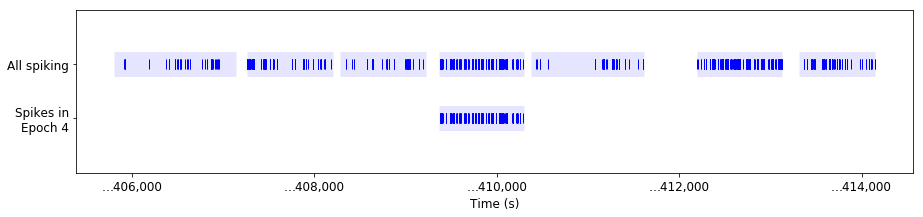

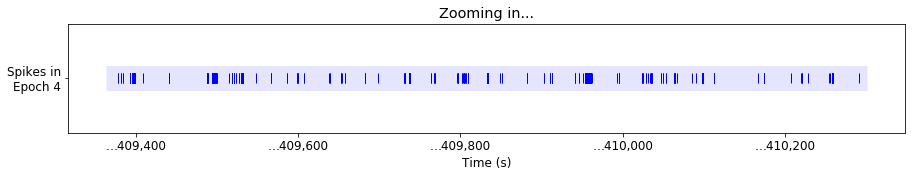

In [45]:
# Dataset Query: get spiking for requested cluster
spikes_t = nwbf.units['spike_times'][d['cluster_id']]
obs_intervals = TimeIntervals(nwbf.units['obs_intervals'][d['cluster_id']])
spiking_all = PointData(point_times=spikes_t, obs_intervals=obs_intervals)

# Time_query on epoch:
# TODO: we need to correctly store Epochs in nwb file, rather than use cluster intervals
epoch_time_query = spiking_all.obs_intervals[d['epoch']-1] 
spiking = spiking_all.time_query(epoch_time_query)


print('*** Spiking for cluster %s ***' % d['cluster_id'])
print('# of spikes = %d' % spiking_all.point_times.shape[0])
print('# of intervals = %d' % len(spiking_all.obs_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_all.obs_intervals.durations()))

print('')
print('*** Spiking for cluster %s during epoch %d ***' % (d['cluster_id'], d['epoch']))
print('# of spikes = %d' % spiking.point_times.shape[0])
print('# of intervals = %d' % len(spiking.obs_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking.obs_intervals.durations()))


# Plot spiking
spikeplots = [(spiking_all, 'All spiking'),
              (spiking, 'Spikes in\nEpoch %s' % d['epoch'])]

fig1 = plt.figure(1, figsize=(15,3))
ax1 = fig1.add_subplot(1,1,1)
plot_PointData_multiple(spikeplots, axis=ax1)

fig2 = plt.figure(2, figsize=(15,2))
ax2 = fig2.add_subplot(1,1,1)
plot_PointData_multiple([spikeplots[1]], axis=ax2)
ax2.set_title("Zooming in...")

pass # suppress output

### Analysis: Find time intervals where speed > threshold
#### ContinuousData (speed), lambda function --> EventData (time periods where animal speed > threshold)
This is an _analysis_, not a query, because we are not simply selecting a subset of a given datatype. i.e. We are not asking for a subset of the speed data, but rather for the intervals where it fulfills a lambda function. The lambda function could have been something different, like "find the times of all upward threshold crossings, and then pad this by 5 seconds on either side.". Regardless of how simple or complex the lambda function is, we consider this to be an analysis. Using the output of this to select a subset of the spiking data, however, is a query.

In [46]:
speed_threshold_fn = lambda x: x > c['speed_threshold']
speed_events = speed.filter_intervals(speed_threshold_fn)

print('*** Times where speed > threshold ***')
print('# of events = %d' % len(speed_events.event_intervals))
print('duration of events = %0.2f s' % np.sum(speed_events.durations()))
print('# of observation intervals = %d' % len(speed_events.obs_intervals))
print('duration of observation intervals = %0.2f s' % np.sum(speed_events.obs_durations()))

# TODO: Plot continuous speed

# TODO: Plot speed events
# fig1 = plt.figure(1, figsize=(15,1.5))
# ax1 = fig1.add_subplot(1,1,1)
# plot_EventData(speed_events, axis=ax1, ypos=1)
# ax1.set_yticks([1])
# ax1.set_yticklabels(['Run events (speed>threshold)']) # eventually use metadata from PointData object
# ax1.set_xlim(xl)
# pass # suppress output

*** Times where speed > threshold ***
# of events = 264
duration of events = 376.94 s
# of observation intervals = 1
duration of observation intervals = 936.96 s


### Query: spiking during time intervals where speed > threshold
#### PointData (spiking), EventData (bouts where speed > threshold) --> PointData (spiking)

*** Spiking where speed > threshold ***
# of spikes = 312
# of intervals = 264
duration of intervals = 376.94 s



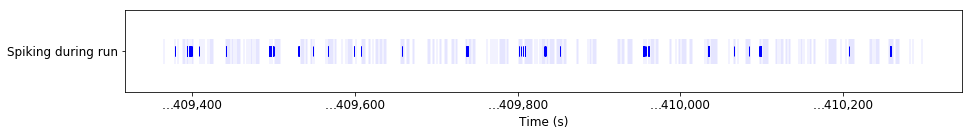

In [47]:
spiking_run = spiking.time_query(speed_events)  # Use the built-in time query method on PointProcess

print('*** Spiking where speed > threshold ***')
print('# of spikes = %d' % len(spiking_run.point_times))
print('# of intervals = %d' % len(spiking_run.obs_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run.obs_intervals.durations()))
print()

# Plot spiking
fig1 = plt.figure(1, figsize=(15,1.5))
ax1 = fig1.add_subplot(1,1,1)
plot_PointData_multiple([(spiking_run, 'Spiking during run')], axis=ax1)

pass # suppress output

### Analysis: Mark animal position at the time of each spike
#### PointData (spiking), ContinuousData (position [m x 2]) --> PointData with marks (spike times with associated positions)

In [48]:
spiking_run_mark_pos = spiking_run.mark_with_ContinuousData(position)

print('*** Spiking where speed > threshold, marked with position ***')
print('# of marked spikes = %d' % len(spiking_run_mark_pos.point_times))
print('# of intervals = %d' % len(spiking_run_mark_pos.obs_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run_mark_pos.obs_intervals.durations()))
print()

ValueError: Can't cast from structure to non-structure, except if the structure only has a single field.

### Query: Get animal locations during running events
#### ContinuousData (position [m x 2]), EventData (bouts where speed > threshold) --> ContinuousData (position [m_new x 2])

In [ ]:
position_run = position.time_query(speed_events)

print('*** Position where speed > threshold ***')
print('# of samples = %d' % position_run.samples.shape[0])
print('# of intervals = %d' % len(position_run.obs_intervals))
print('duration of intervals = %0.2f s' % np.sum(position_run.obs_intervals.durations()))
print()

### Plot spikes by location

In [ ]:
fig1 = plt.figure(1, figsize=(15,15))
ax1 = fig1.add_subplot(1,1,1)
ax1.axis('equal')

# Line showing the animal's movement during the entire epoch
plt.plot(position.samples[:,0], position.samples[:,1], marker='', color='gray', label='Rat location', zorder=1)

# Lines showing animal movement during each interval where it was running
run_label = 'Rat location during movement'
for ivl in position_run.obs_intervals:
    ivl_data = position.time_query(TimeIntervals(ivl)).samples  # x,y position at each timestep 
    plt.plot(ivl_data[:,0], ivl_data[:,1], marker='', color='red', label=run_label, zorder=2)
    run_label = '_' # omit later lines from legend

# Markers for locations where unit spiked during animal running
plt.scatter(spiking_run_mark_pos.marks[:, 0], spiking_run_mark_pos.marks[:, 1], marker='D', s=50, label='Location at spike times during movement', zorder=3)

ax1.legend()
ax1.set_xlabel('X position (m)')
ax1.set_ylabel('Y position (m)')
ax1.set_title('Spike-position map for {} d{} e{} c{}, speed > {:0.1f} cm/s'.format(d['anim'], d['day'], d['epoch'], d['cluster_id'], (c['speed_threshold'] * 100)))
pass